In [1]:
using Catalyst

# NOTE: both models MUST preserve the same ordering of reactions in order to detect 
# how the nonlinear reactions are to be transformed using LMA

rn_nonlinear = @reaction_network begin
      σ_b, g + p → 0
      σ_u*(1-g), 0 ⇒ g + p
      ρ_u, g → g + p
      ρ_b*(1-g), 0 ⇒ p
      1, p → 0
end σ_b σ_u ρ_b ρ_u

rn_linear = @reaction_network begin
      σ_b_LMA, g → 0      # typing ̄σ_b is not allowed it seems
      σ_u*(1-g), 0 ⇒ g
      ρ_u, g → g+p
      (ρ_b*(1-g)), 0 ⇒ p
      1, p → 0
end σ_b_LMA σ_u ρ_b ρ_u

Model ##ReactionSystem#258 with 5 equations
States (2):
  g(t)
  p(t)
Parameters (4):
  σ_b_LMA
  σ_u
  ρ_b
  ρ_u

In [2]:
using MomentClosure

# NOTE: we have to provide the indices of binary variables in the system 
# as they are ordered in the *nonlinear* GRN.
# The distinction here between linear and nonlinear GRNs is important as in some cases 
# the internal ordering of variables of the two Catalyst models can differ
@parameters t
@variables g(t)
binary_vars = [speciesmap(rn_nonlinear)[g]]

LMA_eqs, effective_params = linear_mapping_approximation(rn_nonlinear, rn_linear, binary_vars, combinatoric_ratelaw=false)
display(effective_params)

OrderedCollections.OrderedDict{Any, Any} with 1 entry:
  σ_b_LMA => σ_b*μ₁₁(t)*(μ₁₀(t)^-1)

In [3]:
using Latexify
latexify(LMA_eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& \sigma_{u} - \sigma_{b} \mu{_{11}} - \sigma_{u} \mu{_{10}} \\
\frac{d\mu{_{01}}}{dt} =& \rho_{b} + \rho_{u} \mu{_{10}} - \mu{_{01}} - \rho_{b} \mu{_{10}} \\
\frac{d\mu{_{11}}}{dt} =& \rho_{u} \mu{_{10}} + \sigma_{u} \mu{_{01}} - \mu{_{11}} - \sigma_{u} \mu{_{11}} - \sigma_{b} \mu{_{10}}^{-1} \mu{_{11}}^{2} \\
\frac{d\mu{_{02}}}{dt} =& \rho_{b} + \rho_{u} \mu{_{10}} + 2 \rho_{b} \mu{_{01}} + 2 \rho_{u} \mu{_{11}} + \mu{_{01}} - 2 \mu{_{02}} - \rho_{b} \mu{_{10}} - 2 \rho_{b} \mu{_{11}}
\end{align*}
"

In [4]:
println(latexify(LMA_eqs))

\begin{align*}
\frac{d\mu{_{10}}}{dt} =& \sigma_{u} - \sigma_{b} \mu{_{11}} - \sigma_{u} \mu{_{10}} \\
\frac{d\mu{_{01}}}{dt} =& \rho_{b} + \rho_{u} \mu{_{10}} - \mu{_{01}} - \rho_{b} \mu{_{10}} \\
\frac{d\mu{_{11}}}{dt} =& \rho_{u} \mu{_{10}} + \sigma_{u} \mu{_{01}} - \mu{_{11}} - \sigma_{u} \mu{_{11}} - \sigma_{b} \mu{_{10}}^{-1} \mu{_{11}}^{2} \\
\frac{d\mu{_{02}}}{dt} =& \rho_{b} + \rho_{u} \mu{_{10}} + 2 \rho_{b} \mu{_{01}} + 2 \rho_{u} \mu{_{11}} + \mu{_{01}} - 2 \mu{_{02}} - \rho_{b} \mu{_{10}} - 2 \rho_{b} \mu{_{11}}
\end{align*}



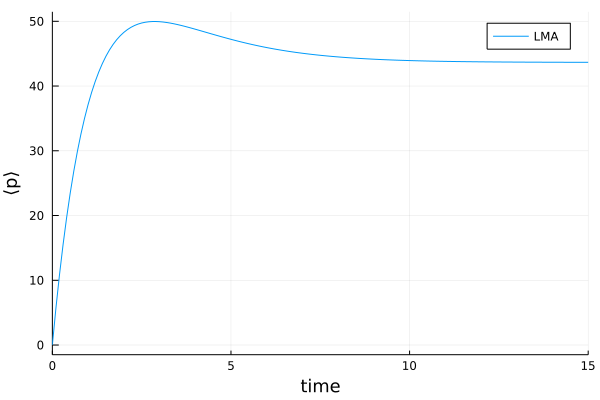


(process:8552): GLib-GIO-WARNING **: 17:16:47.816: Unexpectedly, UWP app `KDEe.V.Okular_20.1202.546.0_x64__7vt06qxq7ptv8' (AUMId `KDEe.V.Okular_7vt06qxq7ptv8!KDEe.V.Okular') supports 5 extensions but has no verbs


In [5]:
using OrdinaryDiffEq, Sundials, Plots

# [g, p] as in species(rn_nonlinear)
u₀ = [1.0, 0.001]
p = [0.004, 0.25, 25.0, 60.0]
tspan = (0., 15.)
dt = 0.1

u₀map = deterministic_IC(u₀, LMA_eqs)
oprob_LMA = ODEProblem(LMA_eqs, u₀map, tspan, p)
sol_LMA = solve(oprob_LMA, CVODE_BDF(), saveat=dt)

plot(sol_LMA, vars=(0, [2]), label="LMA", ylabel="⟨p⟩", xlabel="time", fmt="svg", guidefontsize=12)

In [6]:
#savefig("../docs/src/assets/LMA_feedback_loop_mean_protein_number.svg")

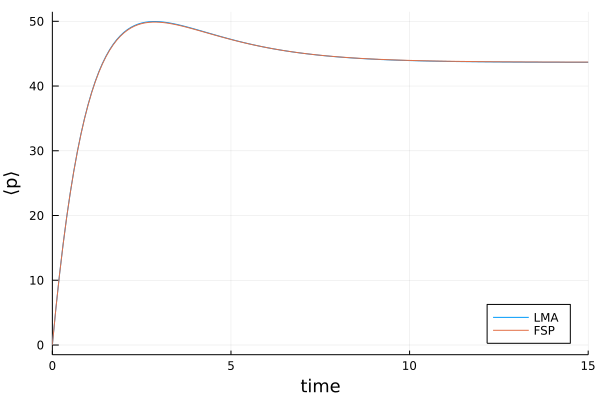

In [7]:
using FiniteStateProjection

fsp_sys = FSPSystem(rn_nonlinear, combinatoric_ratelaw=false)
# Truncate the state space of the system
# The gene has two states (G or G*) whereas we consider protein number from 0 to 100
state_space = [2, 201]

# The initial condition is the matrix of probabilities representing the state of the system
# We assume zero protein and the gene to be in the state G, hence the probability of this 
# specific state should be set to 1 initially
u0 = zeros(state_space...)
u0[2, 1] = 1.0

# construct an ODE problem from the FSPSystem and solve it
fsp_prob = ODEProblem(fsp_sys, u0, tspan, p)
sol_FSP = solve(fsp_prob, CVODE_BDF(), saveat=dt)

# extract the 1st order raw moments from the FSP solution 
μ_FSP = get_moments_FSP(sol_FSP, 1, "raw")
plot!(sol_FSP.t, μ_FSP[(0,1)], label="FSP", legend=:bottomright)

In [8]:
#savefig("../docs/src/assets/LMA+FSP_feedback_loop_mean_protein_number.svg")

In [9]:
using TaylorSeries, HypergeometricFunctions

function t_pFq(α::AbstractVector, β::AbstractVector, a::Taylor1)
    order = a.order
    aux = pFq(α, β, constant_term(a))
    c = Taylor1(aux, order)

    iszero(order) && return c

    coeffs = t_pFq(α.+1, β.+1, Taylor1(a[0:end-1], a.order-1))
    factor = prod(α)/prod(β)
    for k in 1:length(a)-1
        c[k] = sum(i * a[i] * coeffs[k-i] for i in 1:k) * factor / k
    end

    return c

end

t_pFq (generic function with 1 method)

In [10]:
# calculate the raw moments up to time t at a fine temporal resolution
T = 15.0
tspan = (0., T)
dt = 0.001
oprob_LMA = remake(oprob_LMA, tspan=tspan)
sol_LMA = solve(oprob_LMA, CVODE_BDF(), saveat=dt)

# rebuild the symbolic expression for the effective parameter as a function of raw moments
μ_sym = LMA_eqs.odes.states
p_sub = Pair.(LMA_eqs.odes.ps, p)
avg_σ_b_sym = collect(values(effective_params))[1]
fn = build_function(substitute(avg_σ_b_sym, p_sub), μ_sym)
avg_σ_b = eval(fn)
# evaluate the time-averaged value of the effective parameter
@time σ_b_avg = sum(avg_σ_b.(sol_LMA[:])) * dt / T

  0.166009 seconds (303.68 k allocations: 20.226 MiB, 23.01% gc time, 99.56% compilation time)


0.20985247655841632

In [11]:
# need higher-precision numerics as Float64 can be unstable here due to very small numbers
# DoubleFloats is sufficient for this example and much more efficient than BigFloat
using DoubleFloats

# define the numerical values of the parameters
σ_u = p[2]; ρ_b = p[3]; ρ_u = p[4]
Σ = 1 + σ_b_avg + σ_u
ρ_Δ = ρ_b - ρ_u

n = 100 # expansion order (or max protein number to evaluate)
w₀ = -1 # value around which to expand

# compute the Taylor expansion (note the use of Double64)
w = w₀ + Taylor1(Double64, n)
@time f = σ_b_avg/(Σ-1)*exp(-T*(Σ-1))*exp(-ρ_u*w*exp(-T))*t_pFq([σ_u], [Σ], -ρ_Δ*w*exp(-T))
@time g = σ_u/(Σ-1)*exp(-ρ_u*w*exp(-T))*t_pFq([-σ_b_avg], [2-Σ], -ρ_Δ*w*exp(-T))

@time G00 = exp(ρ_b*w)*(f * t_pFq([1-σ_b_avg], [2-Σ], -ρ_Δ*w) +
                  g * t_pFq([1+σ_u], [Σ], -ρ_Δ*w) )

@time G11 = σ_u^(-1) * exp(ρ_b*w) * (-σ_u*f*t_pFq([-σ_b_avg], [2-Σ], -ρ_Δ*w) +
                                σ_b_avg*g*t_pFq([σ_u], [Σ], -ρ_Δ*w))

probs = (G00+G11).coeffs

# check that the probability distribution is more or less normalised to 1
# need higher numerical precision if not
isapprox(sum(probs), 1.0, rtol=1e-2)

  4.622658 seconds (7.25 M allocations: 377.657 MiB, 2.09% gc time, 99.73% compilation time)
  0.110327 seconds (42.19 k allocations: 1.676 MiB, 77.20% gc time, 12.72% compilation time)
  0.081298 seconds (85.06 k allocations: 3.613 MiB)
  0.085832 seconds (85.81 k allocations: 3.670 MiB, 3.77% compilation time)


true

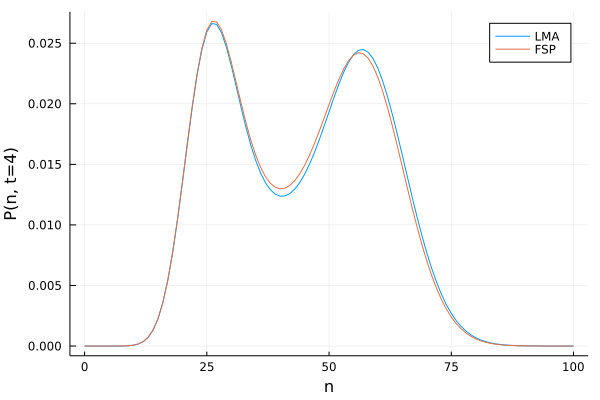

In [12]:
plot(0:n, probs, xlabel="n", ylabel="P(n, t=4)", label="LMA", fmt="svg")
# plot the FSP probability of protein number by marginalising over the gene states
plot!(0:n, sum(sol_FSP[:, 151], dims=1)'[1:n+1], label="FSP")

In [13]:
#savefig("../docs/src/assets/LMA+FSP_feedback_loop_distribution.svg")